### Computer Vision
#### Name: Durva Deshpande
#### Semester: VI
#### Section: A
#### Roll No: 4
### Teacher's Assessment - II

### Problem Statement - I
- Implement the SIFT algorithm to detect and match key points between two images.

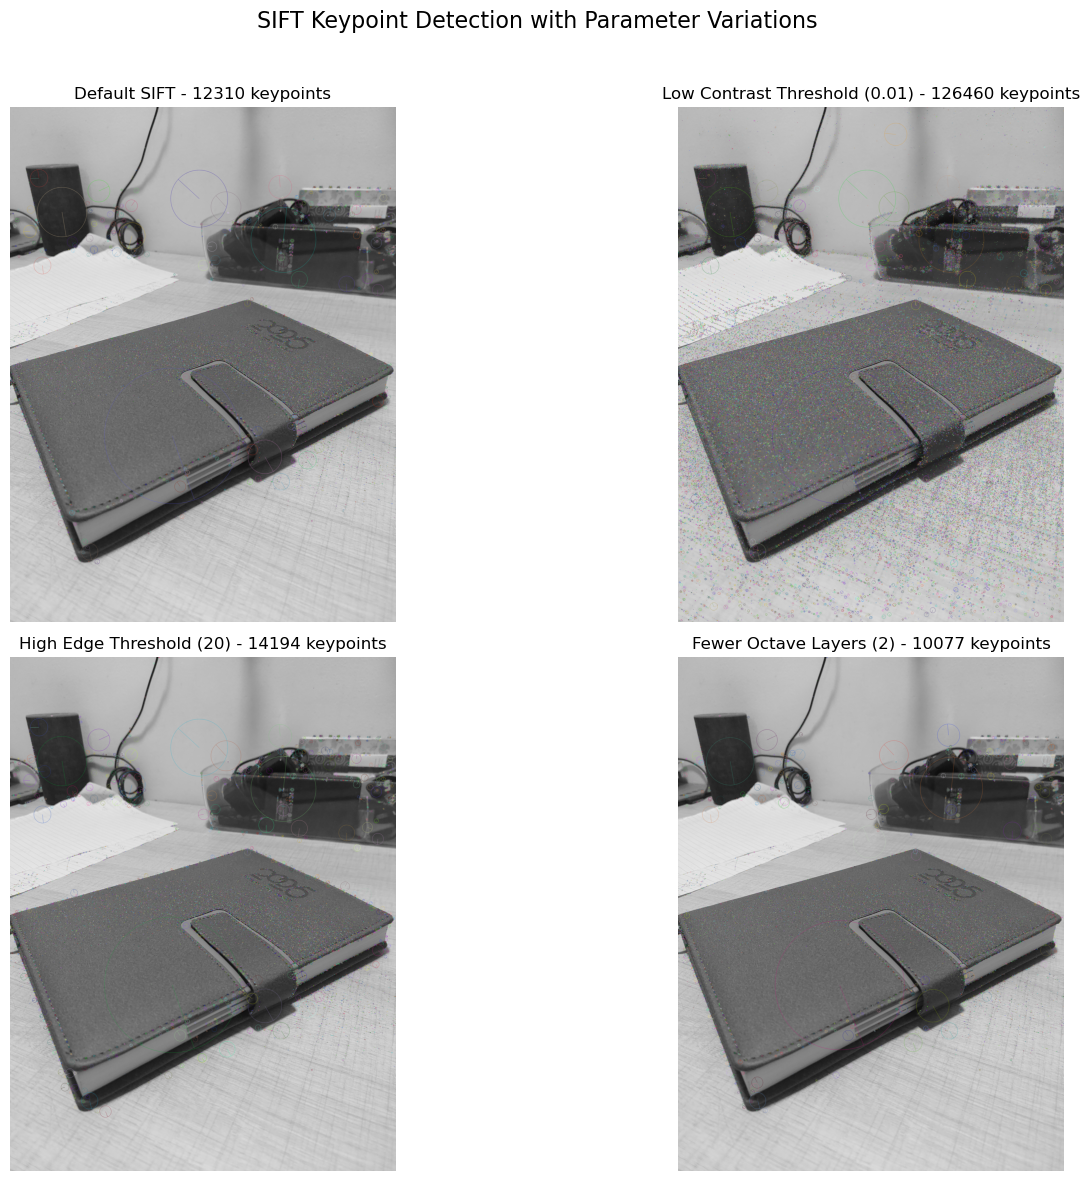

In [28]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load grayscale image
img = cv2.imread('book1.jpg', cv2.IMREAD_GRAYSCALE)

# Function to get image with keypoints
def get_keypoint_image(sift, img):
    kp = sift.detect(img, None)
    img_kp = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img_kp, len(kp)

# Subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 1. Default SIFT
sift_default = cv2.SIFT_create()
img_kp1, kp_count1 = get_keypoint_image(sift_default, img)
axs[0, 0].imshow(img_kp1, cmap='gray')
axs[0, 0].set_title(f'Default SIFT - {kp_count1} keypoints')
axs[0, 0].axis('off')

# 2. Low contrastThreshold
sift_low_contrast = cv2.SIFT_create(contrastThreshold=0.01)
img_kp2, kp_count2 = get_keypoint_image(sift_low_contrast, img)
axs[0, 1].imshow(img_kp2, cmap='gray')
axs[0, 1].set_title(f'Low Contrast Threshold (0.01) - {kp_count2} keypoints')
axs[0, 1].axis('off')

# 3. High edgeThreshold
sift_high_edge = cv2.SIFT_create(edgeThreshold=20)
img_kp3, kp_count3 = get_keypoint_image(sift_high_edge, img)
axs[1, 0].imshow(img_kp3, cmap='gray')
axs[1, 0].set_title(f'High Edge Threshold (20) - {kp_count3} keypoints')
axs[1, 0].axis('off')

# 4. Fewer Octave Layers
sift_low_octave = cv2.SIFT_create(nOctaveLayers=2)
img_kp4, kp_count4 = get_keypoint_image(sift_low_octave, img)
axs[1, 1].imshow(img_kp4, cmap='gray')
axs[1, 1].set_title(f'Fewer Octave Layers (2) - {kp_count4} keypoints')
axs[1, 1].axis('off')

# Display the final figure
plt.suptitle('SIFT Keypoint Detection with Parameter Variations', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### ✅ Conclusion 

1. **Increasing nfeatures** allows more keypoints to be retained after detection. However, after a certain point, it can introduce more noise than useful data.

2. **Lower contrastThreshold** increases sensitivity to low-contrast areas, detecting more keypoints, but might also lead to poor quality matches.

3. **Higher edgeThreshold** suppresses edge-like responses, resulting in fewer but more stable keypoints. Lower values allow more keypoints near edges.

4. **Modifying sigma** affects the scale of Gaussian blur. Smaller values detect finer features; higher values are better for detecting large-scale features.

5. The *best match count* is often a balance between feature richness and quality. Excessive keypoints can reduce accuracy due to false matches.

--

### Problem Statement - II
- Use RANSAC (+SIFT) to remove outlier key point matches and fit a transformation model between two images.

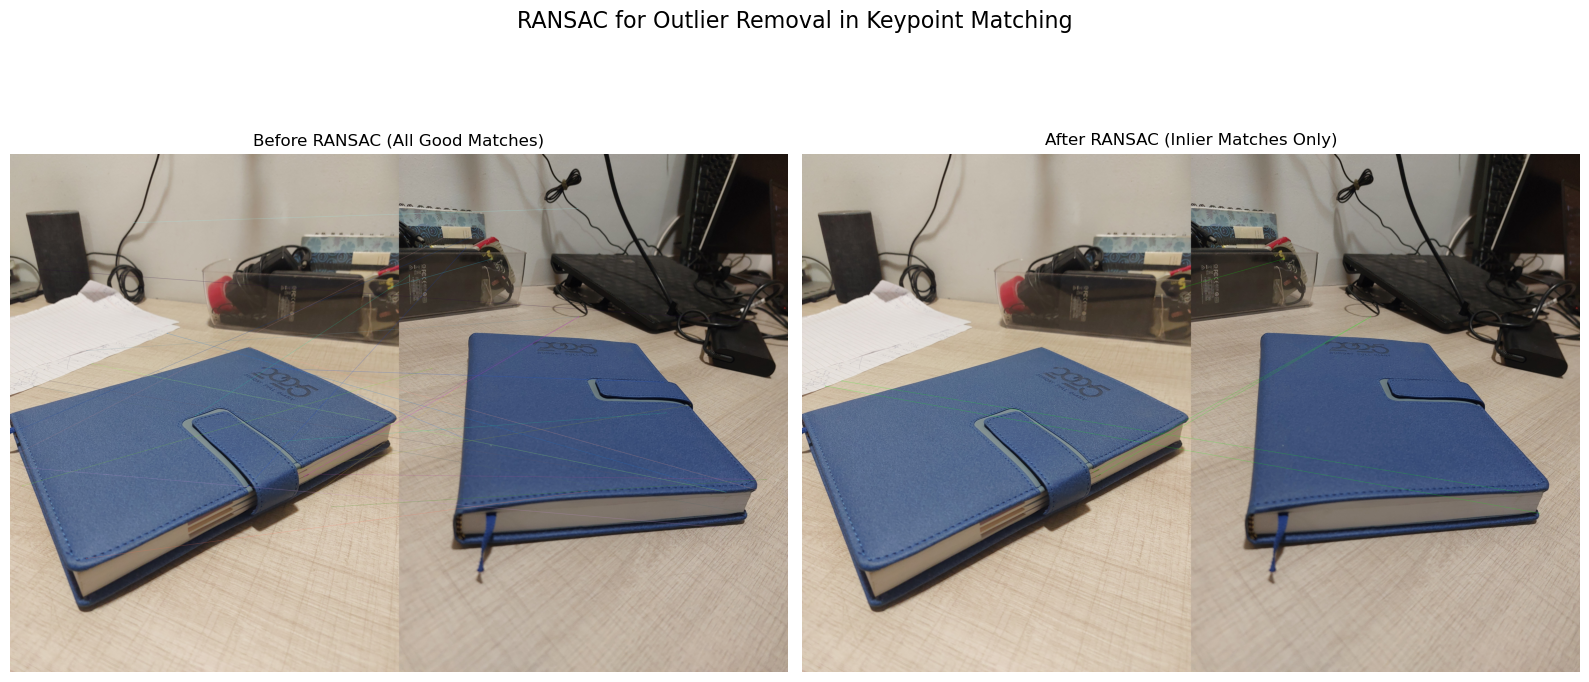

In [31]:
# Loading images
img1 = cv2.imread('book1.jpg')
img2 = cv2.imread('book2.jpg')

# Converting to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# SIFT detector
sift = cv2.SIFT_create()

# Detecting keypoints and descriptors
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# Feature matching using FLANN matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Matched keypoints
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Applying RANSAC to find homography and inliers
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matches_mask = mask.ravel().tolist()

# Drawing matches before and after RANSAC
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=None,
                   matchesMask=matches_mask,
                   flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

img_matches_ransac = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, **draw_params)

# Plotting before and after RANSAC
img_matches_all = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_matches_all, cv2.COLOR_BGR2RGB))
plt.title("Before RANSAC (All Good Matches)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_matches_ransac, cv2.COLOR_BGR2RGB))
plt.title("After RANSAC (Inlier Matches Only)")
plt.axis("off")

plt.suptitle("RANSAC for Outlier Removal in Keypoint Matching", fontsize=16)
plt.tight_layout()
plt.show()

#### 🔍 *Observations*

1. Before RANSAC, many matches can be seen connecting *incorrect or noisy keypoints*, especially if the images have background clutter or repeating patterns.
2. After RANSAC, only *geometrically consistent matches* remain — i.e., points that follow a valid transformation (homography).
3. The final match set is *visually cleaner*, and perfect for tasks like image stitching, alignment, or warping.
4. The *number of inliers vs total good matches* gives an idea of how similar or well-aligned the two images are.
5. Tweaking the *RANSAC reprojection threshold (e.g., 3.0 vs 5.0 vs 10.0)* affects the strictness of inlier filtering:
   - Lower values (e.g., 3.0) remove more matches, keeping only very accurate ones.
   - Higher values (e.g., 10.0) are more tolerant, possibly keeping some weakly consistent matches.

---

#### ✅ *Conclusion*

1. *RANSAC is crucial* in real-world image matching tasks to remove *outlier keypoints* and find a robust geometric relationship.
2. When combined with SIFT (or ORB), RANSAC significantly improves the *reliability of transformations*.
3. It is especially useful for panorama stitching, object tracking, and *motion estimation*.
4. *Parameter tuning (e.g., reprojection threshold)* directly affects how strict the model is — balance is key depending on the use case.
5. Without RANSAC, many false matches can lead to *incorrect transformations or failures in further vision tasks*.

---

### Problem Statement - III
- Implement the Harris corner detector to find and visualize corners in a grayscale image.

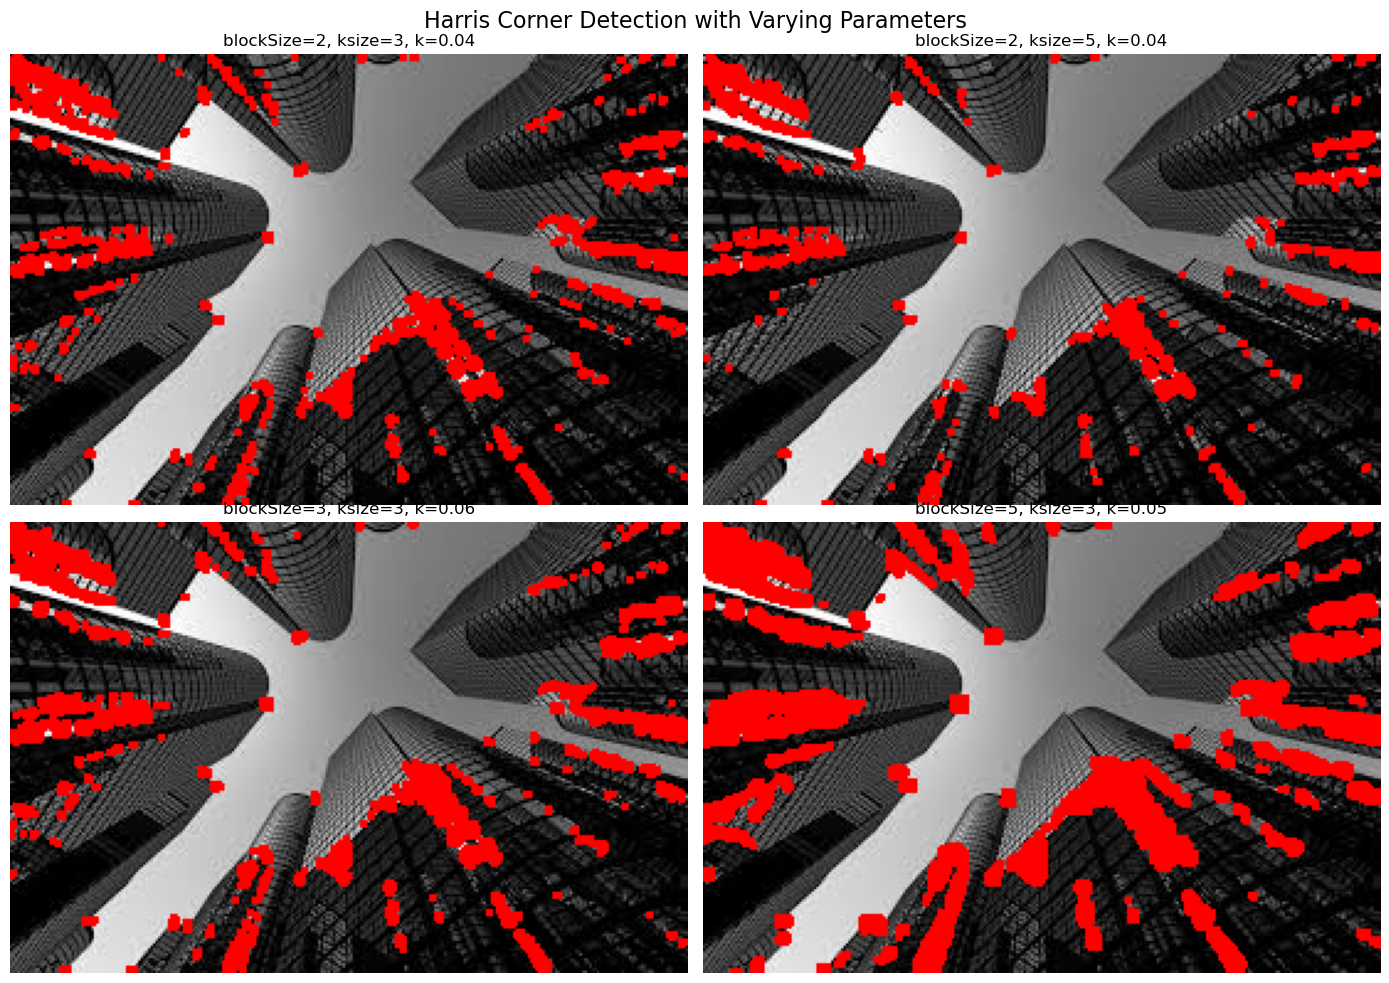

In [30]:
# Reading image in grayscale
img_gray = cv2.imread('harris_image.jpg', cv2.IMREAD_GRAYSCALE)

# Converting to float32
gray = np.float32(img_gray)

# Parameter combinations to test
params = [
    {"blockSize": 2, "ksize": 3, "k": 0.04},
    {"blockSize": 2, "ksize": 5, "k": 0.04},
    {"blockSize": 3, "ksize": 3, "k": 0.06},
    {"blockSize": 5, "ksize": 3, "k": 0.05},
]

# Plotting results
plt.figure(figsize=(14, 10))

for idx, p in enumerate(params):
    # Apply Harris Corner Detector
    dst = cv2.cornerHarris(gray, p["blockSize"], p["ksize"], p["k"])
    dst = cv2.dilate(dst, None)  # Enhance corner visibility

    # Threshold for an optimal value
    threshold = 0.01 * dst.max()
    img_marked = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    img_marked[dst > threshold] = [0, 0, 255]  # Mark corners in red

    # Show in subplot
    plt.subplot(2, 2, idx + 1)
    plt.imshow(cv2.cvtColor(img_marked, cv2.COLOR_BGR2RGB))
    plt.title(f"blockSize={p['blockSize']}, ksize={p['ksize']}, k={p['k']}")
    plt.axis('off')

plt.suptitle("Harris Corner Detection with Varying Parameters", fontsize=16)
plt.tight_layout()
plt.show()

#### 🔍 **Observations**

1. **Effect of `blockSize`:**
   - A **small blockSize (e.g., 2)** detects more fine-grained corners.
   - A **larger blockSize (e.g., 5)** smooths out the detection, often missing smaller corner regions.
   - Larger blocks consider a wider area for corner response, leading to more generalization.

2. **Effect of `ksize` (Sobel kernel size):**
   - A smaller `ksize` (3) gives more **localized** corner detection.
   - Increasing `ksize` (to 5 or higher) results in **blurrier** gradients and may reduce sensitivity to finer edges.

3. **Effect of `k` (Harris free parameter):**
   - Lower values (0.04) tend to detect **more corners**, including weak ones.
   - Higher values (like 0.06) detect **fewer, stronger** corners — this helps suppress false positives but may miss actual corners too.
   - A balanced value around 0.04–0.06 works well in most scenarios.

4. **Image texture impact:**
   - Images with **sharp edges, corners, or textural patterns** show better results.
   - Flat or smooth images (e.g., sky, minimalism) produce fewer or no detected corners.

---

#### ✅ **Conclusion**

1. Harris Corner Detection is a **fast and effective method** for identifying interest points (corners) in grayscale images.
2. Its performance is **highly sensitive to parameter tuning** — especially `blockSize`, `ksize`, and `k`.
3. Best results are achieved on images with **distinct edges and textures**.
4. Harris is **not scale- or rotation-invariant**, so it's more suitable for controlled environments.
5. While Harris is ideal for traditional computer vision tasks, for more robust matching and transformations, **SIFT or ORB** are better suited.

---